In [132]:
from db_helper_functions import get_stock_news_with_finbert_scores_from_db 
from db_helper_functions import get_stock_news_with_finbert_whole_article_scores_from_db
from db_helper_functions import get_stock_news_with_finbert_tone_scores_from_db 
from db_helper_functions import get_stock_news_with_finbert_tone_whole_article_scores_from_db 
from db_helper_functions import get_stock_news_with_bertopic_sentiment_scores_from_db 

%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

import altair as alt
import pandas as pd

In [36]:
finbert_df = get_stock_news_with_finbert_scores_from_db("AAPL")
finbert_whole_article_df = get_stock_news_with_finbert_whole_article_scores_from_db("AAPL")
finbert_tone_df = get_stock_news_with_finbert_tone_scores_from_db("AAPL")
finbert_tone_whole_article_df = get_stock_news_with_finbert_tone_whole_article_scores_from_db("AAPL") 
bertopic_df = get_stock_news_with_bertopic_sentiment_scores_from_db("AAPL") 

## Article Distribution In Each Sentiment Group

In [37]:
# Categorize articles into Positve, Negative and Neutral

def compare_sentiment_score(row):
    if row["positive"] > row["negative"] and row["positive"] > row["neutral"]:
        return "positive"
    elif row["negative"] > row["positive"] and row["negative"] > row["neutral"]:
        return "negative"
    else:
        return "neutral"

finbert_df["sentiment"] = finbert_df.apply(lambda row: compare_sentiment_score(row), axis=1)
finbert_whole_article_df["sentiment"] = finbert_whole_article_df.apply(lambda row: compare_sentiment_score(row), axis=1)
finbert_tone_df["sentiment"] = finbert_tone_df.apply(lambda row: compare_sentiment_score(row), axis=1)
finbert_tone_whole_article_df["sentiment"] = finbert_tone_whole_article_df.apply(lambda row: compare_sentiment_score(row), axis=1)
bertopic_df["sentiment"] = bertopic_df.apply(lambda row: compare_sentiment_score(row), axis=1)

In [63]:
# Function for Drawing Individual Chart
def draw_sentiment_distribution_bar_chart(df:object, subtitle:str):
    sentiments = ["negative", "neutral", "positive"]
    article_counts = []

    for sentiment in sentiments:
        count = len(df[df["sentiment"]==sentiment])
        article_counts.append(count)

    fig, ax = plt.subplots()
    bars = ax.bar(sentiments, article_counts, color='skyblue', align='center')

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

    ax.set_title(f"Number of Articles in each Sentiment Category\n{subtitle}")
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Number')
    
    return ax 

# Function for Drawing Charts on the axis
def draw_sentiment_distribution_bar_chart_on_axis(ax:object, df:object, subtitle:str):
    sentiments = ["negative", "neutral", "positive"]
    article_counts = []

    for sentiment in sentiments:
        count = len(df[df["sentiment"]==sentiment])
        article_counts.append(count)

    bars = ax.bar(sentiments, article_counts, color='skyblue', align='center')

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

    ax.set_title(f"{subtitle}")
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Number')

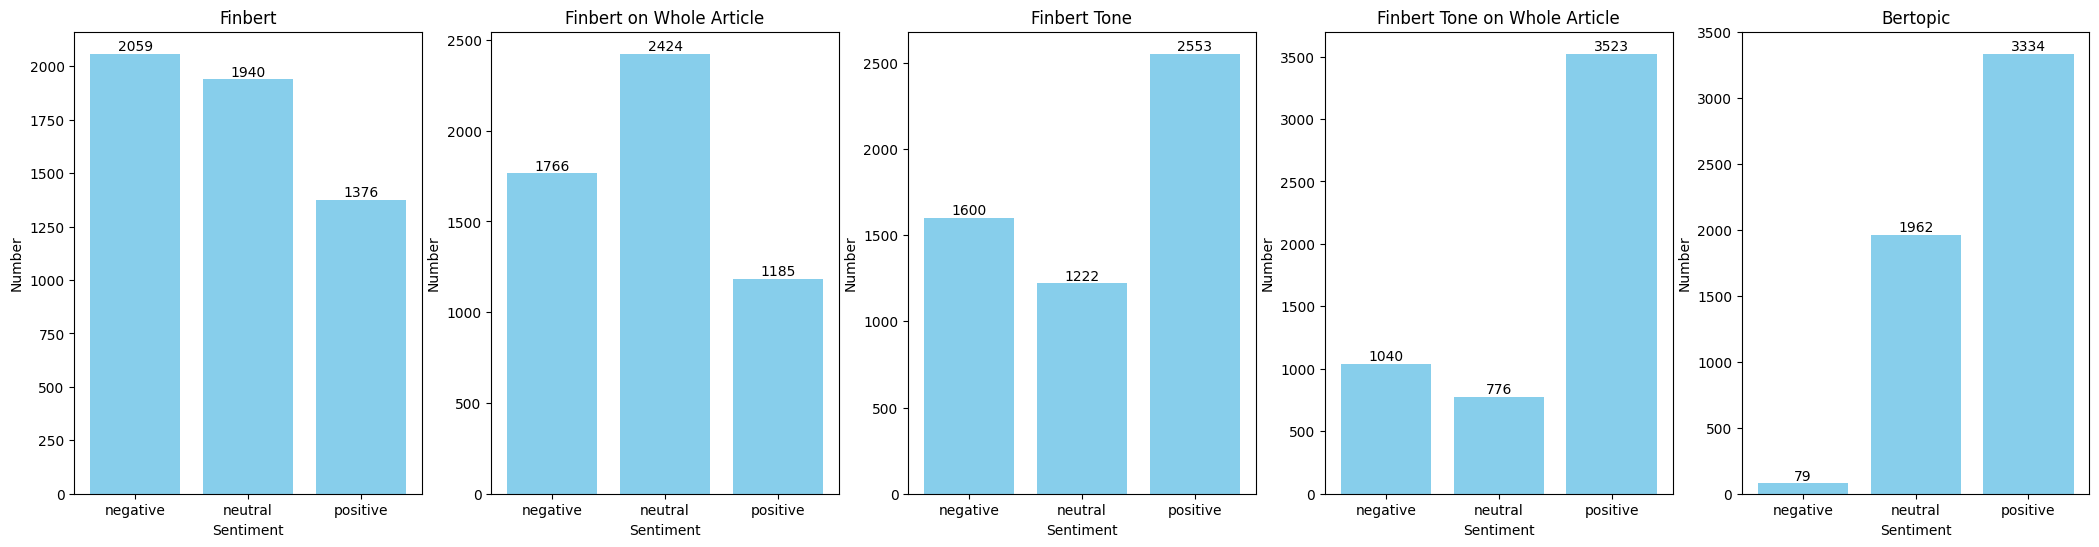

In [71]:
fig, axs = plt.subplots(1, 5, figsize=(26, 6))

draw_sentiment_distribution_bar_chart_on_axis(axs[0], finbert_df, "Finbert")
draw_sentiment_distribution_bar_chart_on_axis(axs[1], finbert_whole_article_df, "Finbert on Whole Article")
draw_sentiment_distribution_bar_chart_on_axis(axs[2], finbert_tone_df, "Finbert Tone")
draw_sentiment_distribution_bar_chart_on_axis(axs[3], finbert_tone_whole_article_df, "Finbert Tone on Whole Article")
draw_sentiment_distribution_bar_chart_on_axis(axs[4], bertopic_df, "Bertopic")

fig

## 1-D Article Sentiment Score distribution  

In [75]:
# Compute the composite sentiment score using following weight assignment
# Composite Score=(1×Positive)+(0×Neutral)+(−1×Negative)

def compute_composite_sentiment_score(row):
    score = (1 * row["positive"]) + (0 * row["neutral"]) + (-1 * row["negative"])
    
    return score

finbert_df["composite_score"] = finbert_df.apply(lambda row: compute_composite_sentiment_score(row), axis=1)
finbert_whole_article_df["composite_score"] = finbert_whole_article_df.apply(lambda row: compute_composite_sentiment_score(row), axis=1)
finbert_tone_df["composite_score"] = finbert_tone_df.apply(lambda row: compute_composite_sentiment_score(row), axis=1)
finbert_tone_whole_article_df["composite_score"] = finbert_tone_whole_article_df.apply(lambda row: compute_composite_sentiment_score(row), axis=1)
bertopic_df["composite_score"] = bertopic_df.apply(lambda row: compute_composite_sentiment_score(row), axis=1)

In [77]:
finbert_df.sample(5)

,id,ticker,date,title,summary,positive,negative,neutral,sentiment,composite_score
4693,3871,AAPL,2022-05-13,Roku's New Deal: Get Voice Remote Pro With Ult...,"The San Jose, California-based company announc...",0.8525,0.0080,0.1395,positive,0.8445
317,541,AAPL,2020-01-29,"The Three ""Cs"" Of Amazon Earnings: Consumers, ...",Will Q4 mark a turnaround?Regardless of the re...,0.2156,0.3049,0.4795,neutral,-0.0893
5114,4809,AAPL,2022-10-19,Why Fear Level Among US Investors Is Decreasing,The CNN Money Fear and Greed index showed furt...,0.0387,0.6696,0.2917,negative,-0.6309
2088,3986,AAPL,2022-06-06,A Peek Into The Markets: US Stock Futures Sign...,Pre-open moversU.S. stock futures traded highe...,0.8841,0.0883,0.0276,positive,0.7958
1839,3461,AAPL,2022-03-07,Gridiron Streaming Fight: Could Apple Beat Ama...,Two of the largest technology companies in the...,0.6925,0.0100,0.2975,positive,0.6825


In [126]:

def drop_unnecessary_columns(df):
    df = df.drop(columns=["date","summary"])
    return df

finbert_df_processed = drop_unnecessary_columns(finbert_df)


In [127]:
alt.data_transformers.disable_max_rows()
chart = alt.Chart(finbert_df_processed).mark_circle(size=80).encode(
    x=alt.X('composite_score', scale=alt.Scale(domain=[-1, 1]), title='Composite Score'),
    color='sentiment',
    tooltip=['title']
).properties(
    width=1500,
    height=150
).interactive()

chart

c:\Users\Steven\AppData\Local\Programs\Python\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\Users\Steven\AppData\Local\Programs\Python\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\Users\Steven\AppData\Local\Programs\Python\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if

alt.Chart(...)

In [150]:
# The above chart is not usefull
# Try Sample the data and pick three  article from the sample to print out thier title

finbert_df_sample = finbert_df_processed.sample(50)

max_row_col1 = finbert_df_sample.loc[finbert_df_sample['negative'].idxmax()].to_frame().T
max_row_col2 = finbert_df_sample.loc[finbert_df_sample['neutral'].idxmax()].to_frame().T
max_row_col3 = finbert_df_sample.loc[finbert_df_sample['positive'].idxmax()].to_frame().T

# Concatenate these rows into a new DataFrame
finbert_df_sample_articlenew_df = pd.concat([max_row_col1, max_row_col2, max_row_col3])

chart = alt.Chart(finbert_df_processed).mark_circle(size=150).encode(
    x=alt.X('composite_score', scale=alt.Scale(domain=[-1, 1]), title='Composite Score'),
    color='sentiment',
    tooltip=['title']
).properties(
    width=1500,
    height=200
).interactive()

text_marks = alt.Chart(finbert_df_sample_articlenew_df).mark_text(align='left', dx=0, dy=15, fontSize=12, fontWeight='bold').encode(
    x='composite_score',
    text='title'
)

chart + text_marks

c:\Users\Steven\AppData\Local\Programs\Python\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\Users\Steven\AppData\Local\Programs\Python\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\Users\Steven\AppData\Local\Programs\Python\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if

alt.LayerChart(...)